#### LSTM Implimentation

#### Step 1: Load and inspect the dataset

In [3]:
import pandas as pd  # Import pandas for data loading, manipulation, and analysis

# Load the dataset from a CSV file into a pandas DataFrame
# 'rnn_sensor_data.csv' should be in the same directory or provide full path
df = pd.read_csv('rnn_sensor_data.csv')

# Display the first 5 rows of the dataset to get a quick look at the structure and data
print(df.head())

   temperature  vibration  pressure  performance_index
0     0.049671   0.472453  0.034829          -0.165201
1     0.006172   0.497070  0.028832          -0.146194
2     0.104758   0.455081 -0.092652          -0.077254
3     0.212267   0.512944  0.059458           0.016974
4     0.056499   0.608590 -0.147008          -0.056961


In [4]:
# Display detailed information about the dataset:
# - Number of rows and columns
# - Column names, data types, and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        10000 non-null  float64
 1   vibration          10000 non-null  float64
 2   pressure           10000 non-null  float64
 3   performance_index  10000 non-null  float64
dtypes: float64(4)
memory usage: 312.6 KB
None


In [5]:
# Display summary statistics for each numeric column:
# - count, mean, std (standard deviation), min, max, and quartiles (25%, 50%, 75%)
print(df.describe())

        temperature     vibration      pressure  performance_index
count  10000.000000  10000.000000  10000.000000       10000.000000
mean       0.002394     -0.002931      2.498504           0.251255
std        0.714484      0.712604      1.446893           0.410038
min       -1.311971     -1.357496     -0.248419          -0.750811
25%       -0.694471     -0.693694      1.239071          -0.076753
50%        0.009477     -0.004069      2.494143           0.251119
75%        0.700943      0.696420      3.747943           0.574135
max        1.368638      1.267052      5.222683           1.282965


#### Step 2: Prepare Features and Target

In [6]:
import numpy as np  # Import NumPy for numerical operations and array handling
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for feature scaling
# Extract the input features ('temperature', 'vibration', 'pressure') as a NumPy array
features = df[['temperature', 'vibration', 'pressure']].values
# Extract the target variable ('performance_index') as a NumPy array
target = df['performance_index'].values
# Create scaler objects for features (X) and target (y)
scaler_x = StandardScaler()  # For scaling features
scaler_y = StandardScaler()  # For scaling target values
# Fit the scaler on features and transform them to have mean=0 and std=1
features_scaled = scaler_x.fit_transform(features)
# Fit the scaler on target values and transform them to mean=0 and std=1
# Reshape target to 2D because StandardScaler expects a 2D array
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))
# Define the sequence length for RNN input (number of time steps in each sample)
SEQ_LENGTH = 40
# Function to create sequences of features and corresponding targets
def create_sequences(X, y, seq_length=SEQ_LENGTH):
    X_seq, y_seq = [], []  # Initialize empty lists for sequences
    for i in range(len(X) - seq_length):
        # Append a sequence of 'seq_length' time steps for features
        X_seq.append(X[i:i+seq_length])
        # Append the target value that occurs right after the sequence
        y_seq.append(y[i+seq_length])
    # Convert lists to NumPy arrays for model compatibility
    return np.array(X_seq), np.array(y_seq)
# Create the RNN-ready sequences for features and targets
X_seq, y_seq = create_sequences(features_scaled, target_scaled)

# Print the shapes of the resulting arrays to verify dimensions
print(f"Input shape: {X_seq.shape}")    # (samples, seq_length, num_features)
print(f"Target shape: {y_seq.shape}")  # (samples, 1)

Input shape: (9960, 40, 3)
Target shape: (9960, 1)


#### Step 3: Train-test split

In [7]:
from sklearn.model_selection import train_test_split  # Import function to split data into training and testing sets
# Split the dataset into training and testing sets
# X_seq: RNN input sequences
# y_seq: Corresponding target values
# test_size=0.2 → 20% of data will be used for testing, 80% for training
# random_state=42 → Ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)
# Print the shape of the training and testing datasets to confirm split
# Each will display: (number_of_samples, sequence_length, num_features) for X, and (number_of_samples, 1) for y
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (7968, 40, 3), (7968, 1)
Test: (1992, 40, 3), (1992, 1)


#### Step 4: Build the LSTM model

In [9]:
import tensorflow as tf  # Import TensorFlow library for deep learning
from tensorflow.keras.models import Sequential  # Import Sequential API to build models layer-by-layer
from tensorflow.keras.layers import LSTM, Dense  # Import LSTM and Dense layers for the RNN
# Build the RNN model using the Sequential API
model = Sequential([
    # First layer: LSTM layer with 64 units, using 'tanh' activation
    # input_shape=(SEQ_LENGTH, 3) → Each sequence has SEQ_LENGTH timesteps and 3 features
    # return_sequences=False → Only output the last timestep's output (suitable for regression)
    LSTM(64, activation='tanh', input_shape=(SEQ_LENGTH, 3), return_sequences=False),
    # Second layer: Dense (fully connected) layer with 32 neurons and 'relu' activation
    Dense(32, activation='relu'),
    # Output layer: Single neuron with no activation (linear output for regression)
    Dense(1)
])
# Compile the model
# optimizer='adam' → Adaptive optimizer for efficient training
# loss='mse' → Mean Squared Error loss function, common for regression tasks
model.compile(optimizer='adam', loss='mse')

In [10]:
# Display the model's architecture and number of parameters
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Step 5: Train the LSTM

In [11]:
# Train the model and store the training history in 'history'
history = model.fit(
    X_train,  # Training input sequences
    y_train,  # Training target values

    validation_split=0.1,  # Use 10% of the training data for validation during training
    epochs=20,  # Number of times the model will see the entire training dataset
    batch_size=64,  # Number of samples processed before updating the model's weights
    verbose=1  # Verbosity mode: 1 = show progress bar with training details
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1111 - val_loss: 0.0404
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0390 - val_loss: 0.0376
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0385 - val_loss: 0.0410
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0382 - val_loss: 0.0400
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0373 - val_loss: 0.0411
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0372 - val_loss: 0.0366
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0370 - val_loss: 0.0383
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0376 - val_loss: 0.0385
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0370 - val_loss: 0.0375
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0368 - val_loss: 0.0367
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0368 - val_loss: 0.0370
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 

#### Step 6: Evaluate the model

In [12]:
from sklearn.metrics import r2_score  # Import r2_score metric
# Evaluate the trained model on the test dataset and get the Mean Squared Error (MSE) loss
test_loss = model.evaluate(X_test, y_test)
# Predict on test data (scaled)
y_pred_scaled = model.predict(X_test)
# Inverse transform predictions and true values back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)
# Calculate R² score (coefficient of determination)
r2 = r2_score(y_true, y_pred)
# Print the test loss value formatted to 4 decimal places
print(f"Test MSE: {test_loss:.4f}")
# Print the R² score formatted to 4 decimal places
print(f"Test R² Score: {r2:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0353
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test MSE: 0.0353
Test R² Score: 0.9638


#### Step 7: Make predictions and invert scaling

In [13]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Use the trained model to predict the target values for the test input sequences (scaled)
y_pred_scaled = model.predict(X_test)

# Convert the scaled predicted values back to the original scale using the inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Convert the scaled true target values back to the original scale for comparison
y_true = scaler_y.inverse_transform(y_test)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


#### Prediction vs Actual Values

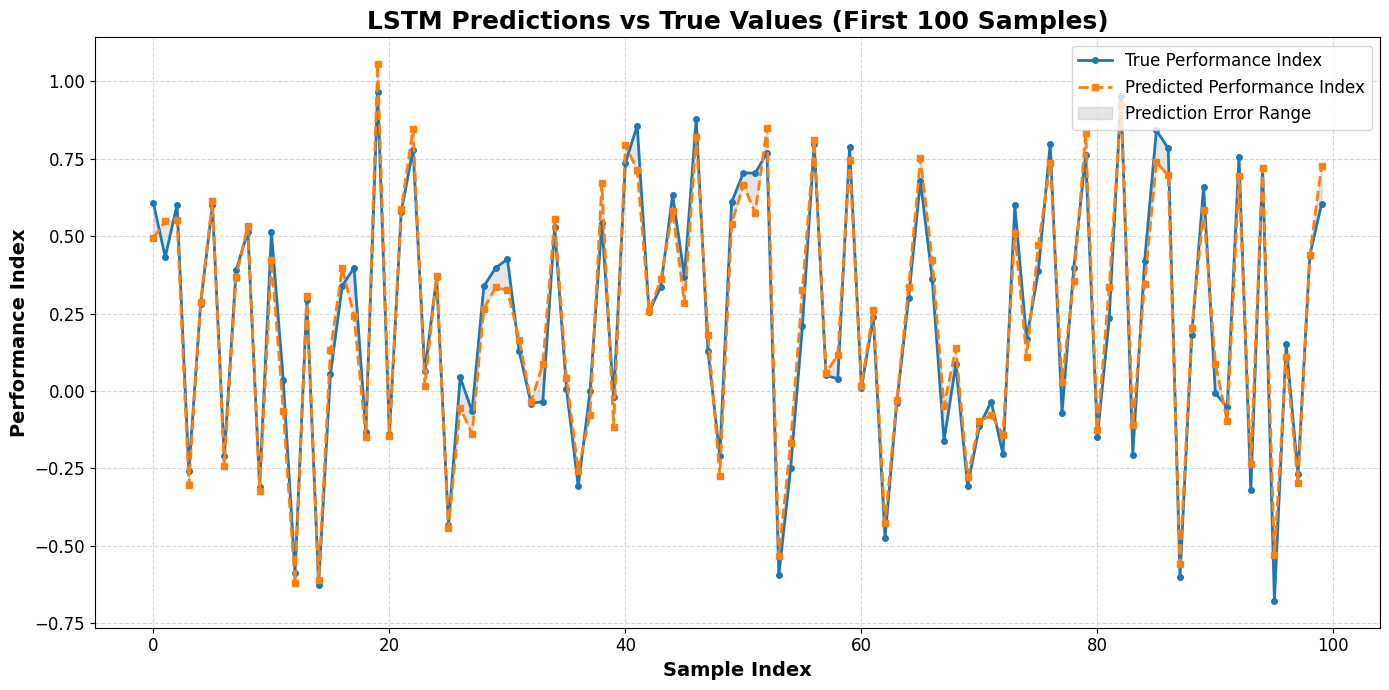

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14,7))

# Plot true values with a solid line and circle markers
plt.plot(y_true[:100], label='True Performance Index', color='#1f77b4', linewidth=2, marker='o', markersize=4)

# Plot predicted values with a dashed line and square markers
plt.plot(y_pred[:100], label='Predicted Performance Index', color='#ff7f0e', linewidth=2, linestyle='--', marker='s', markersize=4)

# Highlight the difference between true and predicted with a semi-transparent fill
plt.fill_between(
    np.arange(100),
    y_true[:100].flatten(),
    y_pred[:100].flatten(),
    color='gray',
    alpha=0.2,
    label='Prediction Error Range'
)

plt.xlabel('Sample Index', fontsize=14, fontweight='bold')
plt.ylabel('Performance Index', fontsize=14, fontweight='bold')
plt.title('LSTM Predictions vs True Values (First 100 Samples)', fontsize=18, fontweight='bold')

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


#### Model Loss During Training LSTM

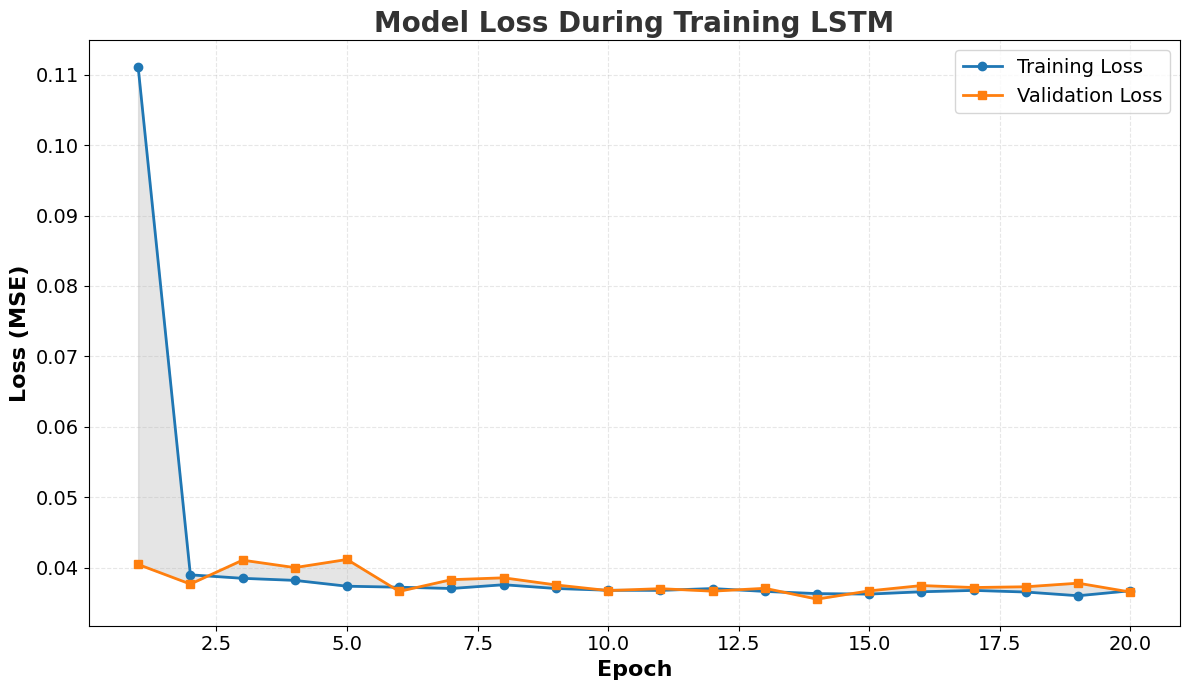

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,7))

epochs = range(1, len(history.history['loss']) + 1)

# Plot training loss with circle markers and a gradient line
plt.plot(epochs, history.history['loss'], label='Training Loss', color='#1f77b4', linewidth=2, marker='o', markersize=6)

# Plot validation loss with square markers and a gradient line
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linewidth=2, marker='s', markersize=6)

# Add a subtle fill between curves to highlight gap between training & validation loss
plt.fill_between(epochs, history.history['loss'], history.history['val_loss'], color='grey', alpha=0.2)

plt.title('Model Loss During Training LSTM', fontsize=20, fontweight='bold', color='#333333')
plt.xlabel('Epoch', fontsize=16, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=16, fontweight='bold')
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


#### Step 8: Save the model

In [16]:
# Save in native Keras format (recommended for TensorFlow >= 2.19)
model.save("lstm_sensor_model.keras")

In [17]:
import joblib
joblib.dump(scaler_x, "scaler_x.save")
joblib.dump(scaler_y, "scaler_y.save")


['scaler_y.save']